## Script for plotting and analyzing results of subjective evaluation

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import config
import json
from pathlib import Path

### Data loading

In [70]:
data_file = f'{config.EVAL_SUBJ_DIR}/pilot_results.json'

with open(data_file) as f:
    data = json.load(f)

In [71]:
df = pd.DataFrame({});

for id in data.keys():
    # print(f"ID: {id}")
    jsPsychData = data[id]['jspsych_data']
    length_jspsych_data = len(jsPsychData)
    # print(f"Length of jspsych_data: {len(jsPsychData)}")
    
    participant_data = {
        "id": data[id]['user_id'],
        "core_initial_visit": data[id]['core_initial_visit'],
        "early_termination": False,
        "termination_code": "COMPLETED",
        "failed_questions": None,
        "age": None,
        "gender": None,
        'country': None,
        'language': None,
        'tinnitus': None,
        'hearing_loss': None,
        'headphone_style': None,
        'trial_type': None,
        'factor': 0,
        'stimulus': None,
        'rating': None,
    };
    
    if (length_jspsych_data < 23): # did not finish the experiment
        last_trial = jsPsychData[-1]

        participant_data["early_termination"] = last_trial['early_termination']
        participant_data["termination_code"] = last_trial['reason']
        
        # find trial that is of trial_type "survey" and fetch "failed_questions"
        survey_trial = next((trial for trial in jsPsychData if trial.get('trial_type', '') == 'survey'), None)
        if survey_trial and 'failed_questions' in survey_trial:
            participant_data["failed_questions"] = survey_trial['failed_questions']
        
        df = pd.concat([df, pd.DataFrame([participant_data])], ignore_index=True);
        continue
    
            
    for trial in jsPsychData:
        if trial['trial_type'] == 'survey': # assumed to be before the experiment
            participant_data['age'] = trial['response']['age']
            participant_data['gender'] = trial['response']['gender']
            participant_data['country'] = trial['response']['country']
            participant_data['language'] = trial['response']['language']
            participant_data['tinnitus'] = trial['response']['tinnitus']
            participant_data['hearing_loss'] = trial['response']['hearing_loss']
            participant_data['headphone_style'] = trial['response']['headphone_style']
        
        if trial['trial_type'] == 'multiple-stimuli-hidden-reference-anchor' and trial['task_type'] in ['mushra_main_experiment']:
            is_tsm = 'tsm' in trial['type']
            if 'tsm' in trial['type']:
                participant_data['trial_type'] = 'tsm'
                participant_data['factor'] = float(trial['type'][3:]) 
            else:
                participant_data['trial_type'] = 'ps'
                participant_data['factor'] = float(trial['type'][2:])
                
            for response, stimulus in zip(trial['response'], trial['stimulus']):
                participant_data['stimulus'] = Path(stimulus).stem
                participant_data['rating'] = int(response)
                df = pd.concat([df, pd.DataFrame([participant_data])], ignore_index=True);
        
    

# sort data frame by early termination
df = df.sort_values(by=['early_termination'], ascending=False);


In [72]:
df

,id,core_initial_visit,early_termination,termination_code,failed_questions,age,gender,country,language,tinnitus,hearing_loss,headphone_style,trial_type,factor,stimulus,rating
0,gn-as-dot-platform|63aed797-1e65-4132-bd71-918...,2025-04-07 10:53:44.343342+00:00,True,PRESCREENING_FAIL,[age],None,None,None,None,None,None,None,None,0.00,None,None
115,pro|61da880fa8422f0ff8e8e078,2025-04-04 09:23:35.862906+00:00,True,HEADPHONE_FAIL,[],None,None,None,None,None,None,None,None,0.00,None,None
226,pro|68da880fa8422f0ff8e8e078,2025-04-04 09:19:40.349270+00:00,True,NO_CONSENT,None,None,None,None,None,None,None,None,None,0.00,None,None
227,pro|69da880fa8422f0ff8e8e078,2025-04-04 09:20:10.345739+00:00,True,NO_CONSENT,None,None,None,None,None,None,None,None,None,0.00,None,None
114,pro|62da880fa8422f0ff8e8e078,2025-04-04 09:22:52.997957+00:00,True,PRESCREENING_FAIL,[headphone_style],None,None,None,None,None,None,None,None,0.00,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,gn-as-dot-platform|9ed68611-b9a6-477e-9ace-f59...,2025-04-02 11:12:53.023566+00:00,False,COMPLETED,None,35,Man (including Trans Male/Trans Man),Denmark,[English],No,No,Over-the-ear,tsm,0.75,pv,90
163,gn-as-dot-platform|9ed68611-b9a6-477e-9ace-f59...,2025-04-02 11:12:53.023566+00:00,False,COMPLETED,None,35,Man (including Trans Male/Trans Man),Denmark,[English],No,No,Over-the-ear,tsm,0.75,hps,79
162,gn-as-dot-platform|9ed68611-b9a6-477e-9ace-f59...,2025-04-02 11:12:53.023566+00:00,False,COMPLETED,None,35,Man (including Trans Male/Trans Man),Denmark,[English],No,No,Over-the-ear,tsm,0.75,anchor,43
161,gn-as-dot-platform|9ed68611-b9a6-477e-9ace-f59...,2025-04-02 11:12:53.023566+00:00,False,COMPLETED,None,35,Man (including Trans Male/Trans Man),Denmark,[English],No,No,Over-the-ear,tsm,0.75,ref,100


In [73]:
df_completed = df[df['early_termination'] == False]
df_completed;

df_completed = df_completed[df_completed['country'] == 'Denmark']
# df_completed = df_completed[df_completed['stimulus'] != 'ref']
df_completed

,id,core_initial_visit,early_termination,termination_code,failed_questions,age,gender,country,language,tinnitus,hearing_loss,headphone_style,trial_type,factor,stimulus,rating
322,gn-as-dot-platform|59f5f7b0-a152-4ea6-845f-b20...,2025-04-08 06:12:02.790643+00:00,False,COMPLETED,None,25,Man (including Trans Male/Trans Man),Denmark,"[English, Danish]",No,No,Over-the-ear,tsm,0.75,tsmnet,28
335,gn-as-dot-platform|59f5f7b0-a152-4ea6-845f-b20...,2025-04-08 06:12:02.790643+00:00,False,COMPLETED,None,25,Man (including Trans Male/Trans Man),Denmark,"[English, Danish]",No,No,Over-the-ear,tsm,1.50,ref,100
345,waad|U5Ys2zEMEM_QB7DcKjySJouArWPpLDNoY_JdAFdProY,2025-04-08 07:33:15.597864+00:00,False,COMPLETED,None,30,Man (including Trans Male/Trans Man),Denmark,"[Danish, English, German]",No,No,Over-the-ear,ps,7.00,librosaps,33
344,waad|U5Ys2zEMEM_QB7DcKjySJouArWPpLDNoY_JdAFdProY,2025-04-08 07:33:15.597864+00:00,False,COMPLETED,None,30,Man (including Trans Male/Trans Man),Denmark,"[Danish, English, German]",No,No,Over-the-ear,ps,7.00,anchor,0
343,waad|U5Ys2zEMEM_QB7DcKjySJouArWPpLDNoY_JdAFdProY,2025-04-08 07:33:15.597864+00:00,False,COMPLETED,None,30,Man (including Trans Male/Trans Man),Denmark,"[Danish, English, German]",No,No,Over-the-ear,ps,7.00,nmps,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,gn-as-dot-platform|9ed68611-b9a6-477e-9ace-f59...,2025-04-02 11:12:53.023566+00:00,False,COMPLETED,None,35,Man (including Trans Male/Trans Man),Denmark,[English],No,No,Over-the-ear,tsm,0.75,pv,90
163,gn-as-dot-platform|9ed68611-b9a6-477e-9ace-f59...,2025-04-02 11:12:53.023566+00:00,False,COMPLETED,None,35,Man (including Trans Male/Trans Man),Denmark,[English],No,No,Over-the-ear,tsm,0.75,hps,79
162,gn-as-dot-platform|9ed68611-b9a6-477e-9ace-f59...,2025-04-02 11:12:53.023566+00:00,False,COMPLETED,None,35,Man (including Trans Male/Trans Man),Denmark,[English],No,No,Over-the-ear,tsm,0.75,anchor,43
161,gn-as-dot-platform|9ed68611-b9a6-477e-9ace-f59...,2025-04-02 11:12:53.023566+00:00,False,COMPLETED,None,35,Man (including Trans Male/Trans Man),Denmark,[English],No,No,Over-the-ear,tsm,0.75,ref,100


Gender distribution:
gender
Man (including Trans Male/Trans Man)          5
Woman (including Trans Female/Trans Woman)    2
Name: count, dtype: int64

Countries:
['Denmark']
Country distribution:
country
Denmark    7
Name: count, dtype: int64

Headphone styles:
headphone_style
Over-the-ear    7
Name: count, dtype: int64


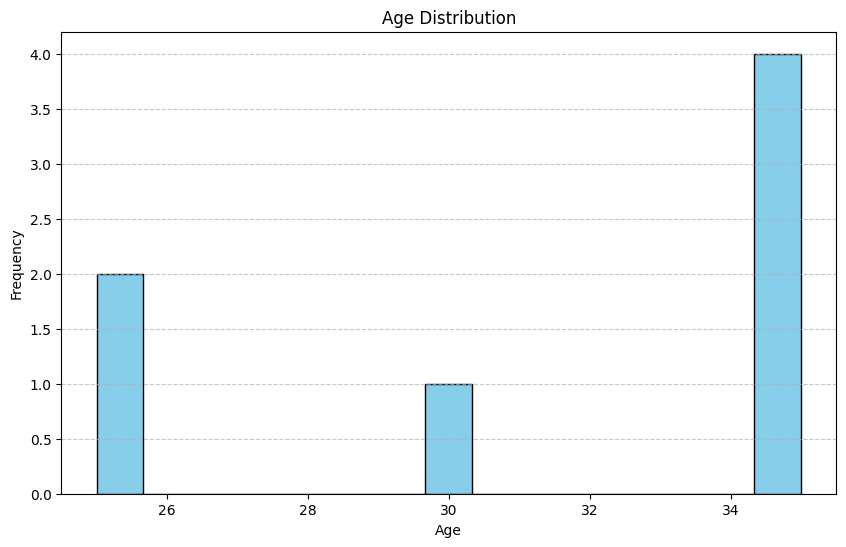

In [74]:
# get demographic data and plot it
demographic_data = df_completed[['id', 'age', 'gender', 'country', 'language', 'tinnitus', 'hearing_loss', 'headphone_style']]
demographic_data = demographic_data.drop_duplicates(subset=['id'])
demographic_data = demographic_data.reset_index(drop=True)

demographic_data

# Count the number of women and men
gender_counts = demographic_data['gender'].value_counts()
print("Gender distribution:")
print(gender_counts)

# List unique countries
unique_countries = demographic_data['country'].unique()
print("\nCountries:")
print(unique_countries)
country_counts = demographic_data['country'].value_counts()
print("Country distribution:")
print(country_counts)


# Count headphone styles
headphone_style_counts = demographic_data['headphone_style'].value_counts()
print("\nHeadphone styles:")
print(headphone_style_counts)

# Plot age distribution
plt.figure(figsize=(10, 6))
demographic_data['age'] = pd.to_numeric(demographic_data['age'], errors='coerce')  # Convert age to numeric
demographic_data['age'].dropna().plot(kind='hist', bins=15, color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [75]:
# group by "id" and find the lowest and the highest score for each id
df_participants = df_completed.copy()
df_participants = df_participants[['id', 'trial_type',  'rating']]
df_participants = df_participants.groupby(['id', 'trial_type']).agg(['min', 'max'])
df_participants;



    trial_type   stimulus rating
322        tsm     tsmnet     28
335        tsm        ref    100
345         ps  librosaps     33
344         ps     anchor      0
343         ps       nmps      7
..         ...        ...    ...
164        tsm         pv     90
163        tsm        hps     79
162        tsm     anchor     43
161        tsm        ref    100
502        tsm         pv     65

[385 rows x 3 columns]


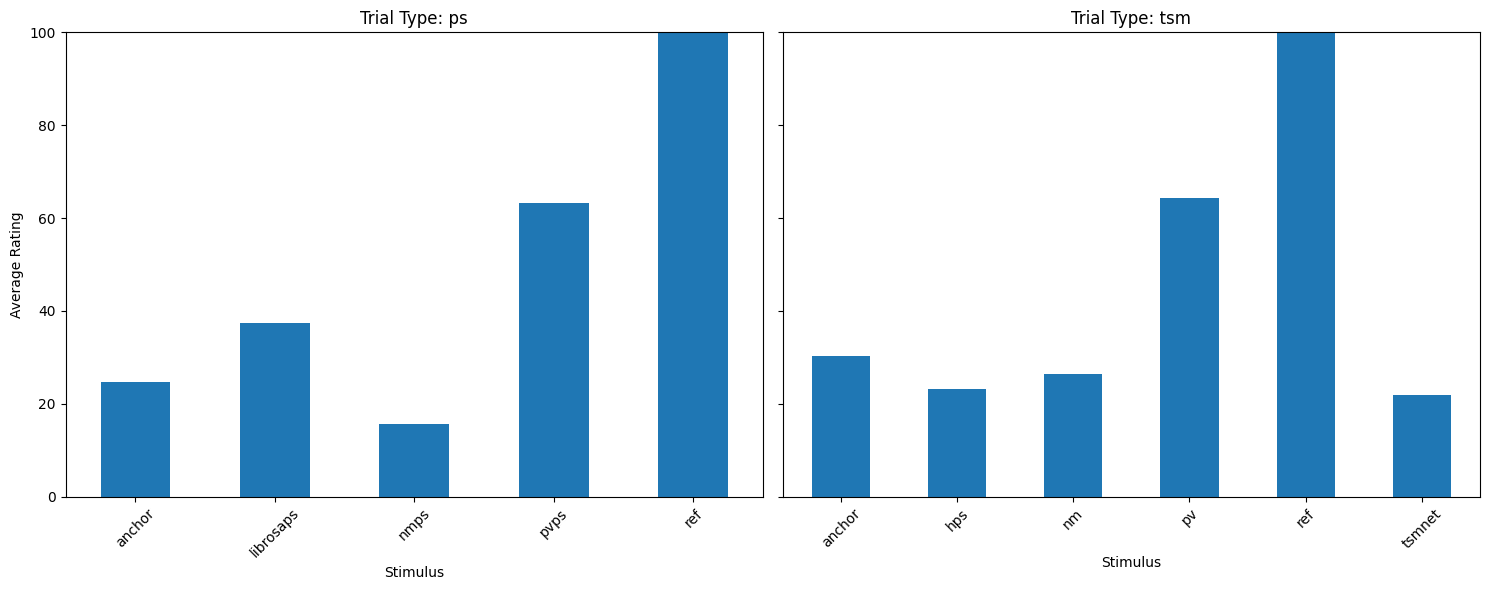

In [76]:
df_ratings = df_completed.copy()
df_ratings = df_ratings[['trial_type', 'stimulus', 'rating']]
print(df_ratings)

# group by trial_type and stimulus and plot the ratings
df_ratings_grouped = df_ratings.groupby(['trial_type', 'stimulus']).mean().reset_index()

fig, axes = plt.subplots(nrows=1, ncols=len(df_ratings_grouped['trial_type'].unique()), figsize=(15, 6), sharey=True)

for ax, trial_type in zip(axes, df_ratings_grouped['trial_type'].unique()):
    df_subset = df_ratings_grouped[df_ratings_grouped['trial_type'] == trial_type]
    df_subset.plot(kind='bar', x='stimulus', y='rating', ax=ax, legend=False)
    ax.set_title(f'Trial Type: {trial_type}')
    ax.set_xlabel('Stimulus')
    ax.set_ylabel('Average Rating')
    ax.set_xticklabels(df_subset['stimulus'], rotation=45)
    ax.set_ylim(0, 100)

fig.tight_layout()
plt.show()

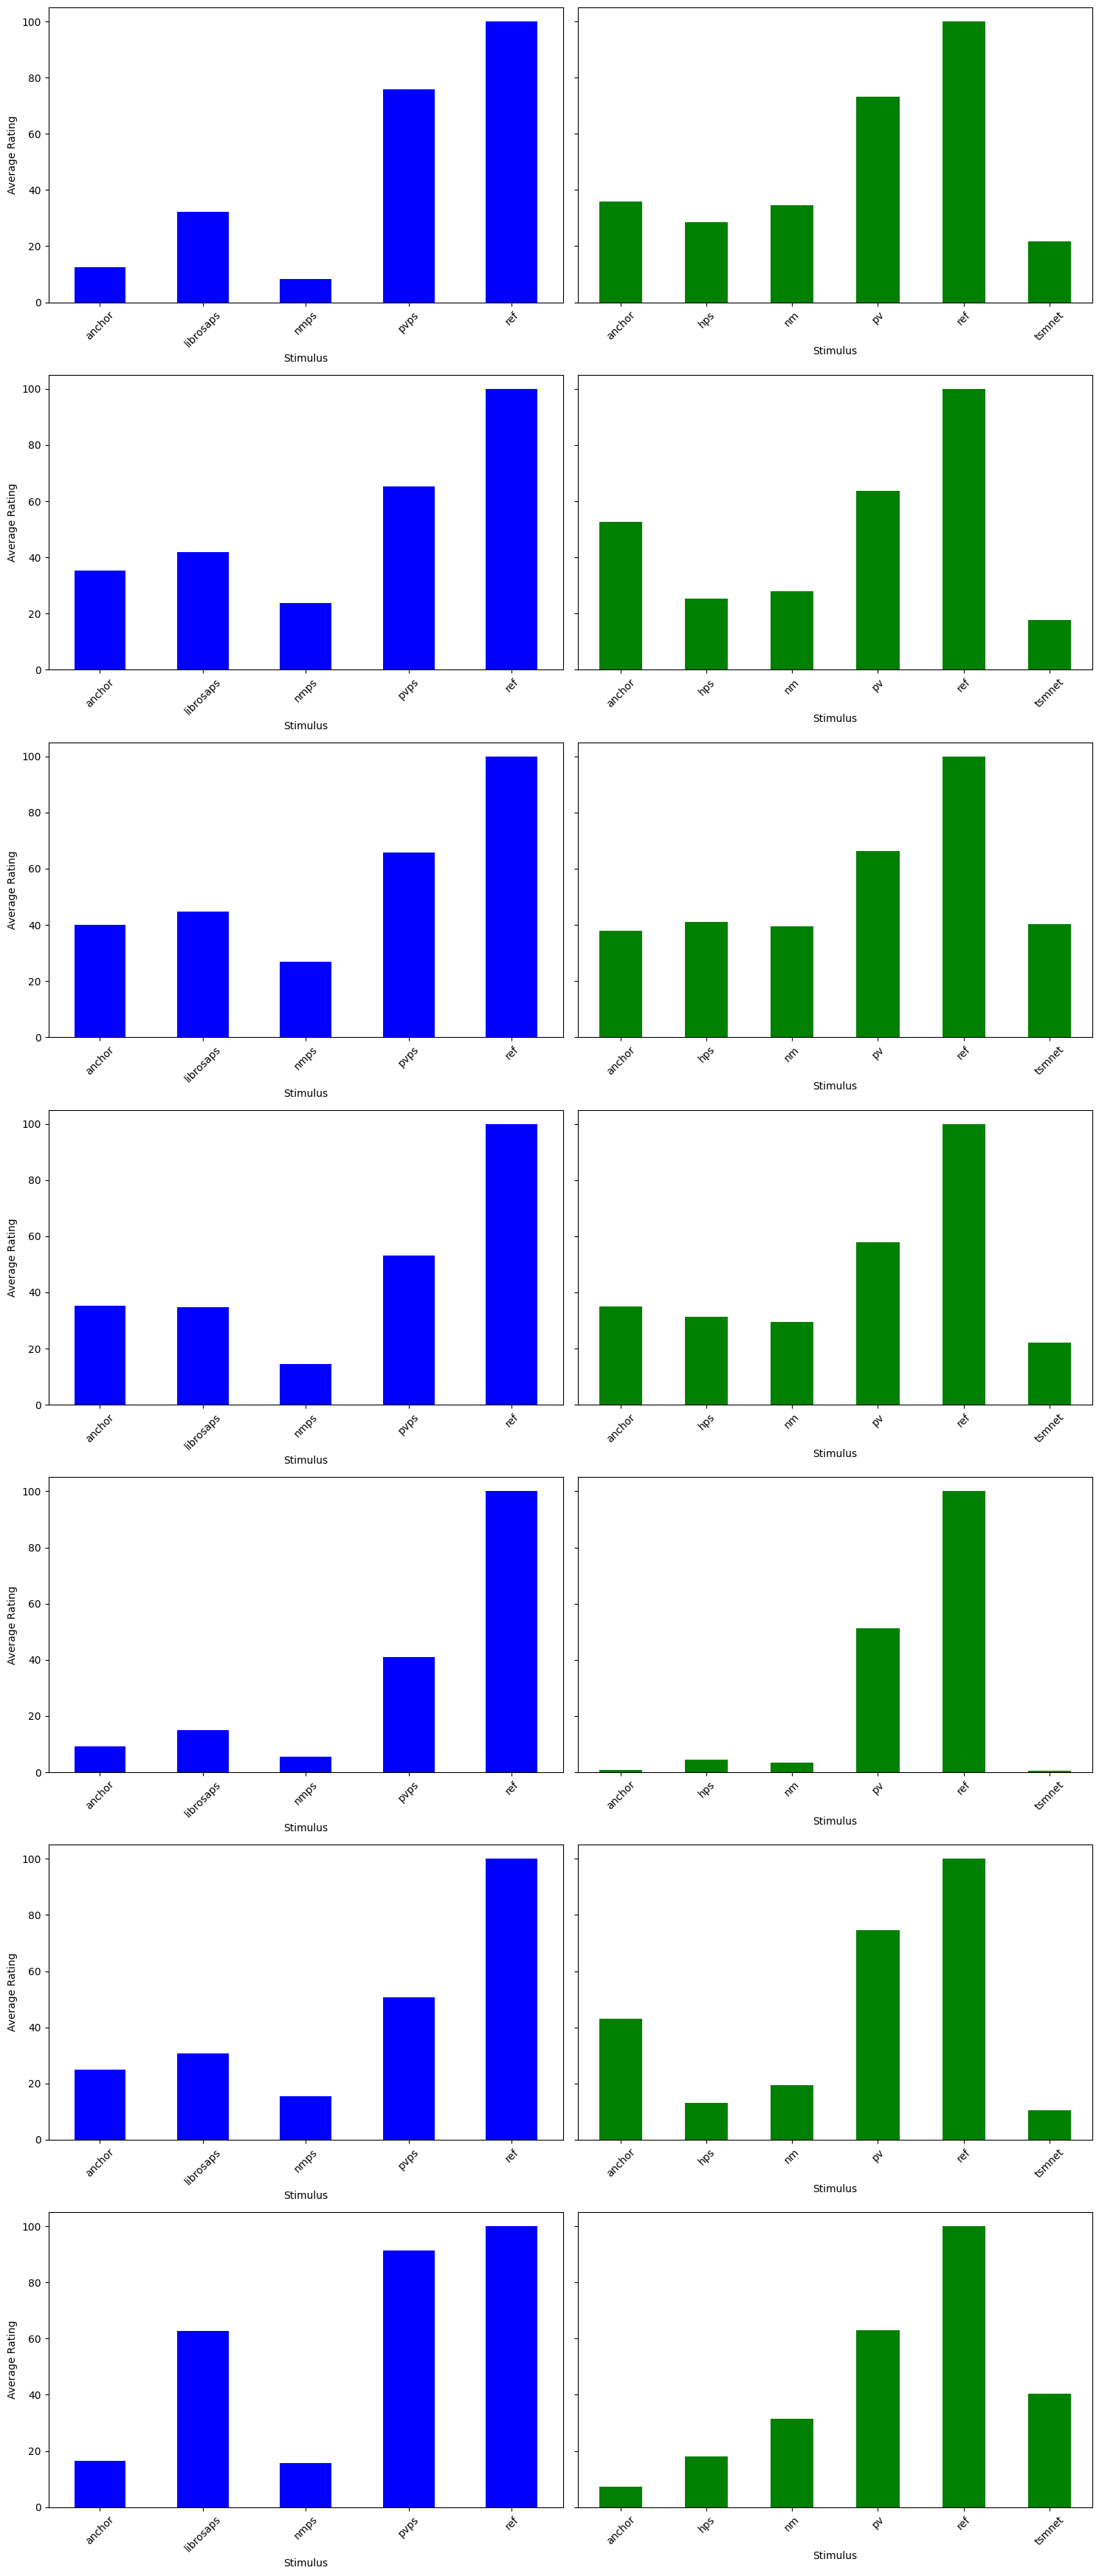

In [77]:
df_ratings = df_completed.copy()
df_ratings = df_ratings[['id', 'trial_type', 'stimulus', 'rating']]
df_ratings = df_ratings.sort_values(by=['stimulus'])
# Get unique participants
unique_participants = df_ratings['id'].unique()

# Create subplots with one row per participant and two columns (one for ps, one for tsm)
fig, axes = plt.subplots(nrows=len(unique_participants), ncols=2, figsize=(15, 5 * len(unique_participants)), sharey=True)

for ax_row, participant_id in zip(axes, unique_participants):
    # Filter data for the current participant
    participant_data = df_ratings[df_ratings['id'] == participant_id]
    
    # Plot ps ratings
    ps_data = participant_data[participant_data['trial_type'] == 'ps']
    if not ps_data.empty:
        ps_data.groupby('stimulus')['rating'].mean().plot(kind='bar', ax=ax_row[0], color='blue', legend=False)
        ax_row[0].set_xlabel('Stimulus')
        ax_row[0].set_ylabel('Average Rating')
        ax_row[0].set_xticklabels(ps_data['stimulus'].unique(), rotation=45)
    else:
        ax_row[0].set_visible(False)

    # Plot tsm ratings
    tsm_data = participant_data[participant_data['trial_type'] == 'tsm']
    if not tsm_data.empty:
        tsm_data.groupby('stimulus')['rating'].mean().plot(kind='bar', ax=ax_row[1], color='green', legend=False)
        ax_row[1].set_xlabel('Stimulus')
        ax_row[1].set_ylabel('Average Rating')
        ax_row[1].set_xticklabels(tsm_data['stimulus'].unique(), rotation=45)
    else:
        ax_row[1].set_visible(False)

fig.tight_layout()
plt.show()

In [78]:
# map rating score from 0-100 to 1-5 MOS scale
df_mos_scaled = df_completed.copy()
df_mos_scaled['rating'] = df_mos_scaled['rating'].map(lambda x: (x/100)*4+1)
df_mos_scaled;

In [79]:
df_short = df_mos_scaled[['trial_type', 'factor', 'stimulus', 'rating']]
df_grouped = df_short.groupby(['trial_type', 'factor', 'stimulus']).agg(['mean', 'std'])
df_grouped

rating          
                                 mean       std
trial_type factor stimulus                     
ps         -7.00  anchor     1.868571  0.611322
                  librosaps  2.120000  0.964987
                  nmps       1.342857  0.407174
                  pvps       2.937143  0.923430
                  ref        5.000000  0.000000
           -1.00  anchor     2.622857  0.795607
                  librosaps  2.205714  0.938205
                  nmps       1.891429  0.634440
                  pvps       3.954286  0.780915
                  ref        5.000000  0.000000
            1.00  anchor     1.988571  0.802567
                  librosaps  2.702857  0.892893
                  nmps       1.662857  0.496310
                  pvps       3.634286  0.704813
                  ref        5.000000  0.000000
            3.00  anchor     1.708571  0.471997
                  librosaps  2.788571  0.701128
                  nmps       1.920000  0.612753
                  pvps       4.017143  0.777297
                  ref        5.000000  0.000000
            7.00  anchor     1.765714  0.591238
                  librosaps  2.668571  0.830009
                  nmps       1.331429  0.345419
                  pvps       3.120000  1.102724
                  ref        5.000000  0.000000
tsm         0.75  anchor     2.114286  0.748484
                  hps        2.382857  0.950749
                  nm         2.165714  0.943872
                  pv         4.182857  0.552259
                  ref        5.000000  0.000000
                  tsmnet     1.514286  0.534380
            0.85  anchor     3.034286  1.225600
                  hps        1.720000  0.607509
                  nm         2.297143  0.666876
                  pv         3.874286  0.477454
                  ref        5.000000  0.000000
                  tsmnet     2.640000  0.957775
            1.25  anchor     2.417143  1.059524
                  hps        2.085714  0.495542
                  nm         2.148571  0.546852
                  pv         3.274286  0.528862
                  ref        5.000000  0.000000
                  tsmnet     1.731429  0.397803
            1.35  anchor     2.051429  0.931727
                  hps        1.782857  0.374420
                  nm         1.862857  0.593681
                  pv         3.091429  0.653081
                  ref        5.000000  0.000000
                  tsmnet     1.834286  0.622438
            1.50  anchor     1.462857  0.437482
                  hps        1.651429  0.543919
                  nm         1.828571  0.631491
                  pv         3.428571  0.360529
                  ref        5.000000  0.000000
                  tsmnet     1.668571  0.676349

### Cliff's Delta, Wilcoxon and other tests

In [80]:
from scipy.stats import norm

# calculate confidence intervals
confidence_level = 0.95
z_score = norm.ppf(1 - (1 - confidence_level) / 2)

df_grouped['rating', 'ci'] = z_score * (df_grouped['rating', 'std'] / np.sqrt(df_grouped['rating', 'std'].count()))

df_grouped;

In [81]:
df_ps = df_short[df_short['trial_type'] == 'ps']
df_ps

,trial_type,factor,stimulus,rating
345,ps,7.0,librosaps,2.32
344,ps,7.0,anchor,1.00
343,ps,7.0,nmps,1.28
342,ps,1.0,ref,5.00
341,ps,1.0,nmps,1.40
...,...,...,...,...
175,ps,-7.0,nmps,1.00
174,ps,-7.0,librosaps,1.60
173,ps,-7.0,pvps,1.92
172,ps,-7.0,ref,5.00


In [82]:
df_tsm = df_short[df_short['trial_type'] == 'tsm']
df_tsm

,trial_type,factor,stimulus,rating
322,tsm,0.75,tsmnet,2.12
335,tsm,1.50,ref,5.00
320,tsm,0.75,ref,5.00
337,tsm,1.50,pv,3.00
336,tsm,1.50,tsmnet,2.52
...,...,...,...,...
164,tsm,0.75,pv,4.60
163,tsm,0.75,hps,4.16
162,tsm,0.75,anchor,2.72
161,tsm,0.75,ref,5.00


In [83]:
from scipy.stats import wilcoxon


def run_wilcoxon_test(dataframe, stimulus_test):
    # Get unique stimuli excluding 'stimulus_test'
    unique_stimuli = dataframe['stimulus'].unique()
    unique_stimuli = unique_stimuli[unique_stimuli != stimulus_test]
    ps_scores = dataframe[dataframe['stimulus'] == stimulus_test]['rating']

    # Perform the Wilcoxon signed-rank test for 'stimulus_test' against each unique stimulus
    results = {}
    for stimulus in unique_stimuli:
        stimulus_scores = dataframe[dataframe['stimulus'] == stimulus]['rating']
        stat, p_value = wilcoxon(ps_scores, stimulus_scores)
        results[stimulus] = {'stat': stat, 'p_value': p_value}

    # Print the results
    for stimulus, result in results.items():
        print(f'Wilcoxon signed-rank test pairing {stimulus_test} with {stimulus}:')
        print(f'  Statistic: {result["stat"]}')
        print(f'  p-value: {result["p_value"]}\n')
        
    return results

tsm_wilcoxon_results = run_wilcoxon_test(df_tsm, 'pv')
ps_wilcoxon_results = run_wilcoxon_test(df_ps, 'pvps')

Wilcoxon signed-rank test pairing pv with tsmnet:
  Statistic: 3.0
  p-value: 4.77580313947626e-07

Wilcoxon signed-rank test pairing pv with ref:
  Statistic: 0.0
  p-value: 2.458773978508773e-07

Wilcoxon signed-rank test pairing pv with anchor:
  Statistic: 27.5
  p-value: 2.4873789661980327e-06

Wilcoxon signed-rank test pairing pv with nm:
  Statistic: 1.0
  p-value: 3.9830702248436443e-07

Wilcoxon signed-rank test pairing pv with hps:
  Statistic: 2.5
  p-value: 3.0744424581322606e-07

Wilcoxon signed-rank test pairing pvps with librosaps:
  Statistic: 1.0
  p-value: 5.897110436707923e-07

Wilcoxon signed-rank test pairing pvps with anchor:
  Statistic: 5.0
  p-value: 5.700527818782641e-07

Wilcoxon signed-rank test pairing pvps with nmps:
  Statistic: 0.0
  p-value: 2.474739598535175e-07

Wilcoxon signed-rank test pairing pvps with ref:
  Statistic: 0.0
  p-value: 2.4656055418917745e-07



In [84]:
from cliffs_delta import cliffs_delta

def run_cliffs_delta(dataframe, stimulus_test):
    # Get unique stimuli excluding 'stimulus_test'
    unique_stimuli = dataframe['stimulus'].unique()
    unique_stimuli = unique_stimuli[unique_stimuli != stimulus_test]

    # Perform the Cliff's Delta test for 'stimulus_test' against each unique stimulus
    results = {}
    for stimulus in unique_stimuli:
        stimulus_scores = dataframe[dataframe['stimulus'] == stimulus]['rating']
        stimulus_test_scores = dataframe[dataframe['stimulus'] == stimulus_test]['rating']
        d, res = cliffs_delta(stimulus_scores, stimulus_test_scores)
        results[stimulus] = {'delta': np.abs(d), 'magnitude': res}

    # Print the results
    for stimulus, result in results.items():
        print(f"Cliff's Delta test pairing {stimulus_test} with {stimulus}:")
        print(f"  Delta: {result['delta']}")
        print(f"  Magnitude: {result['magnitude']}\n")
        
    return results

tsm_cliffs_delta_results = run_cliffs_delta(df_tsm, 'pv')
ps_cliffs_delta_results = run_cliffs_delta(df_ps, 'pvps')

Cliff's Delta test pairing pv with tsmnet:
  Delta: 0.8987755102040816
  Magnitude: large

Cliff's Delta test pairing pv with ref:
  Delta: 1.0
  Magnitude: large

Cliff's Delta test pairing pv with anchor:
  Delta: 0.7028571428571428
  Magnitude: large

Cliff's Delta test pairing pv with nm:
  Delta: 0.8881632653061224
  Magnitude: large

Cliff's Delta test pairing pv with hps:
  Delta: 0.9175510204081633
  Magnitude: large

Cliff's Delta test pairing pvps with librosaps:
  Delta: 0.5885714285714285
  Magnitude: large

Cliff's Delta test pairing pvps with anchor:
  Delta: 0.7975510204081633
  Magnitude: large

Cliff's Delta test pairing pvps with nmps:
  Delta: 0.9012244897959184
  Magnitude: large

Cliff's Delta test pairing pvps with ref:
  Delta: 1.0
  Magnitude: large



In [85]:
from effect_size_analysis.cliff_delta import cliff_delta

# cliff_delta(s1=x,s2=y,alpha=0.05,accurate_ci=True)
def run_cliffs_delta_analysis(dataframe, stimulus_test):
    # Get unique stimuli excluding 'PS'
    unique_stimuli = dataframe['stimulus'].unique()
    unique_stimuli = unique_stimuli[unique_stimuli != stimulus_test]

    # Perform the Cliff's Delta test for 'PS' against each unique stimulus
    results = {}
    for stimulus in unique_stimuli:
        stimulus_scores = dataframe[dataframe['stimulus'] == stimulus]['rating']
        stimulus_test_scores = dataframe[dataframe['stimulus'] == stimulus_test]['rating']
        d, res = cliff_delta(s2=stimulus_test_scores, s1=stimulus_scores, alpha=0.05, accurate_ci=True)
        results[stimulus] = {'delta': np.abs(d), 'magnitude': np.sort(np.abs(res))}

    # Print the results
    for stimulus, result in results.items():
        print(f"Cliff's δ Effect Size test pairing {stimulus_test} with {stimulus}:")
        print(f"  Delta: {result['delta']}")
        print(f"  Confidende Interval: {result['magnitude']}\n")
        
    return results

tsm_cliffs_delta_analysis_results = run_cliffs_delta_analysis(df_tsm, 'pv')
ps_cliffs_delta_analysis_results = run_cliffs_delta_analysis(df_ps, 'pvps')

Cliff's δ Effect Size test pairing pv with tsmnet:
  Delta: 0.8987755102040816
  Confidende Interval: [0.73359327 0.96368404]

Cliff's δ Effect Size test pairing pv with ref:
  Delta: 1.0
  Confidende Interval: [nan nan]

Cliff's δ Effect Size test pairing pv with anchor:
  Delta: 0.7028571428571428
  Confidende Interval: [0.48428938 0.83884909]

Cliff's δ Effect Size test pairing pv with nm:
  Delta: 0.8881632653061224
  Confidende Interval: [0.74128319 0.95386514]

Cliff's δ Effect Size test pairing pv with hps:
  Delta: 0.9175510204081633
  Confidende Interval: [0.7441691  0.97510555]

Cliff's δ Effect Size test pairing pvps with librosaps:
  Delta: 0.5885714285714285
  Confidende Interval: [0.34525703 0.75774845]

Cliff's δ Effect Size test pairing pvps with anchor:
  Delta: 0.7975510204081633
  Confidende Interval: [0.61014572 0.90043981]

Cliff's δ Effect Size test pairing pvps with nmps:
  Delta: 0.9012244897959184
  Confidende Interval: [0.76928348 0.95944142]

Cliff's δ Effect

/Users/mariapolak/miniconda3/envs/smc10/lib/python3.11/site-packages/effect_size_analysis/cliff_delta.py:94: RuntimeWarning: invalid value encountered in scalar divide
  (delta_val - delta_val ** 3 - ci_size) / denom_corretion,
/Users/mariapolak/miniconda3/envs/smc10/lib/python3.11/site-packages/effect_size_analysis/cliff_delta.py:95: RuntimeWarning: invalid value encountered in scalar divide
  (delta_val - delta_val ** 3 + ci_size) / denom_corretion,


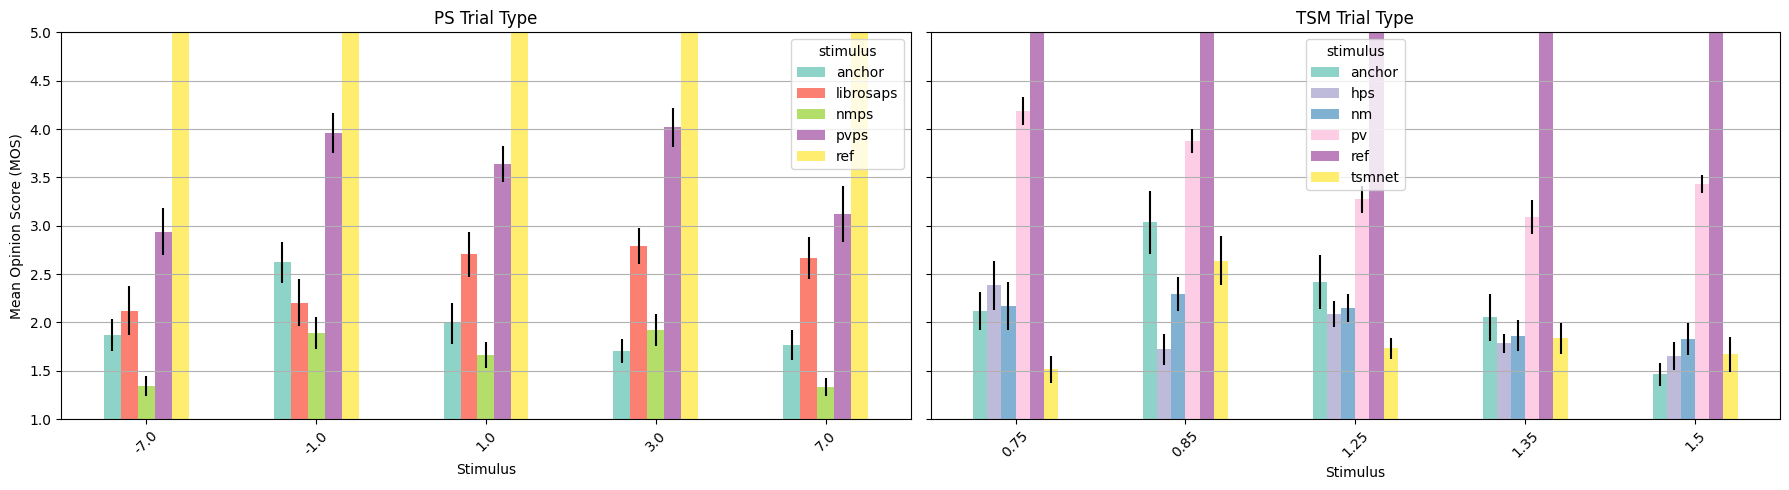

In [86]:
# Separate data by trial_type
df_ps = df_grouped.xs('ps', level='trial_type')
df_tsm = df_grouped.xs('tsm', level='trial_type')

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5), sharey=True)

# Plot for 'ps'
df_ps['rating'].unstack().plot(kind='bar', y='mean', yerr='ci', ax=axes[0], colormap='Set3')
axes[0].yaxis.grid(True)
axes[0].set_title('PS Trial Type')
axes[0].set_xlabel('Stimulus')
axes[0].set_ylabel('Mean Opinion Score (MOS)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_ylim(1, 5)

# Plot for 'tsm'
df_tsm['rating'].unstack().plot(kind='bar', y='mean', yerr='ci', ax=axes[1], colormap='Set3')
axes[1].yaxis.grid(True)
axes[1].set_title('TSM Trial Type')
axes[1].set_xlabel('Stimulus')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_ylim(1, 5)

fig.tight_layout()
plt.show()